In [1]:
import os
import subprocess
import rasterio
import json
import tempfile
import math
import shapely

import pandas as pd
import geopandas as geopd
import numpy as np
import matplotlib.pyplot as plt


from shapely.geometry import Point
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.windows import from_bounds
from rasterio.features import rasterize
from IPython.display import display
from matplotlib.colors import ListedColormap

%matplotlib inline
plt.rcParams['figure.dpi'] = 300

In [2]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches, from https://stackoverflow.com/questions/44970010/axes-class-set-explicitly-size-width-height-of-axes-in-given-units"""
    
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [3]:
# Changes between old and new
squares_path = "/home/iiro/Documents/Koulutyöt/Gradu/data/grids/uudet opetusruudut.gpkg"
annotations_path = "/home/iiro/Documents/Koulutyöt/Gradu/data/digitointi/digitoinnit.gpkg"
# Changes between old and new
raster_path = "/home/iiro/Documents/Koulutyöt/Gradu/data/clip_kartat/newer_v2.vrt"
""" jokainen kilometrin ruutu sisältää 590,5 pikseliä, jota lähin kahdella riittävästi  jakautuva luku on 576.
Näin ollen saadaan neljä kuvaa kuvakoolla 288 x 288 (kuvat pidetään pieninä jotta pieneet kohteet huomataan paremmin)
Tämä koko sallii 5 jakoa kakkosella, mikä riittää U-nettiin.
otosten keskukset ovat näin ollen 145 pikseliä reunasta (reunaefektien välttämiseksi), jolloin reunaan jää yhden pikselin kolo
"""
# Not the actual value, fine tuned to create right sized image output
pixel_size = 1.685
# Valid range is 145 – 150
sample_offset_px = 148

image_tmp_dir = "/tmp/images"
label_tmp_dir = "/tmp/labels"
train_dir = "/home/iiro/Documents/Koulutyöt/Gradu/data/opetus/opetus"
train_label_dir = "/home/iiro/Documents/Koulutyöt/Gradu/data/opetus/opetusannotaatiot"
test_dir = "/home/iiro/Documents/Koulutyöt/Gradu/data/opetus/testi"
test_label_dir = "/home/iiro/Documents/Koulutyöt/Gradu/data/opetus/testausannotaatiot"
dirs = [image_tmp_dir, label_tmp_dir ,train_dir, test_dir, train_label_dir, test_label_dir]

for directory in dirs:
    if not os.path.isdir(directory):
        os.mkdir(directory)


offset_substraction = sample_offset_px - 144
sample_offset_m = pixel_size * sample_offset_px
sample_buffer_size_m = pixel_size * (sample_offset_px - offset_substraction)

squares = geopd.read_file(squares_path)
# Changes between old and new
annotations = geopd.read_file(annotations_path, layer="Kaikki uudet")

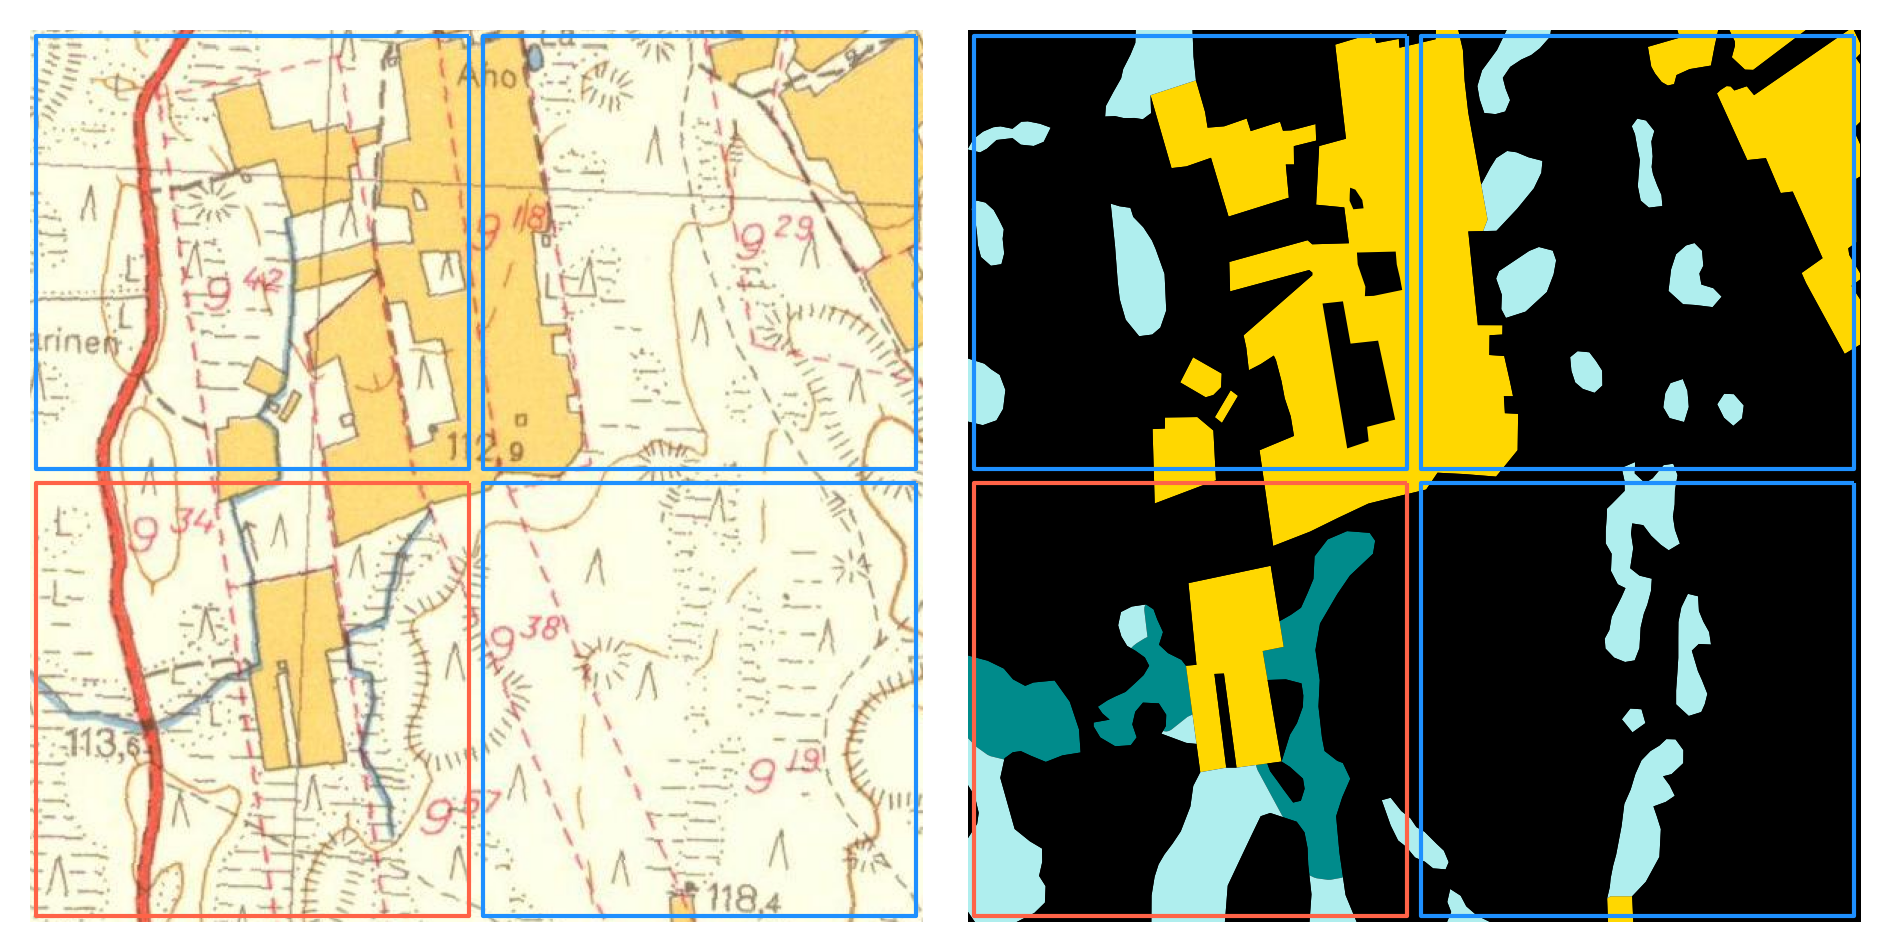

In [10]:
raster_path = "/home/iiro/Documents/Koulutyöt/Gradu/data/clip_kartat/newer_v2.vrt"

# Counter for the training samples, starts from 909 with older data
j=0

# not efficient but the amount of points is relatively small and the code is run only once
errors = []
# Counting starts from 303 for older data
for i, square in enumerate(squares.iterrows(), 0):
    
    if i != 246:
        continue
    
    # Image tmp path
    image_path = os.path.join(image_tmp_dir, str(i) + '.tif')
    #  Label tmp path
    label_path = os.path.join(label_tmp_dir, str(i) + '.tif')
    
    poly = (square[-1]['geometry'])
    plot_poly = geopd.GeoDataFrame(geometry=[poly], crs=annotations.crs)
    corner_points = [i for i in list(poly.exterior.coords)]
    x_W, y_N = corner_points[0]
    x_E, y_S = corner_points[2]
    NW_sample = Point(x_W + sample_offset_m, y_N - sample_offset_m)
    NE_sample = Point(x_E - sample_offset_m, y_N - sample_offset_m)
    SE_sample = Point(x_E - sample_offset_m, y_S + sample_offset_m)
    SW_sample = Point(x_W + sample_offset_m, y_S + sample_offset_m)
    sample_points = geopd.GeoSeries([NW_sample, NE_sample, SE_sample, SW_sample])
    # Square buffer
    sample_squares = sample_points.buffer(sample_buffer_size_m, cap_style=3)
    
    testing_square = sample_squares[3]

    annotation_km2 = annotations.cx[x_W: x_E, y_S:y_N]

    # Needed because holes are plotted incorrectly
    background = plot_poly.overlay(annotations, how='difference')
    
    with rasterio.open(raster_path) as src:
        # Opens only the required, very small area instead of the entire huge raster. Alpha band is not needed as it is only for visualisations
        raster = src.read((1,2,3), boundless=True, window=from_bounds(left=x_W, bottom=y_S, right=x_E, top=y_N, transform=src.transform))
        meta = src.meta.copy()
        
    # Constructing the correct transform for the window area
    meta['transform'] = rasterio.transform.from_bounds(west=x_W, south=y_S, east=x_E, north=y_N, width=raster.shape[1], height=raster.shape[2])
    meta['width'] = raster.shape[1]
    meta['height'] = raster.shape[2]
    meta['count'] = 3
    # The results are saved as geotiff
    meta['driver'] = "GTiff"
    
    # Saving the image and reopening it to get it ready for clipping
    
    with rasterio.open(image_path, 'w', **meta) as dest:
        dest.write(raster)

    
    # Saving a black raster to help with background
    with rasterio.open(label_path, 'w', **meta) as dest:
        dest.write(np.where(raster==-1, raster, 0))

    
    train_geo_series = geopd.GeoSeries([NW_sample, NE_sample, SE_sample])
    test_geo_series = geopd.GeoSeries([SW_sample])

    #plt.style.use('Solarize_Light2')
    fig, [ax1, ax2] = plt.subplots(1, 2)
    with rasterio.open(image_path) as image:
        ax1 = show(image, ax=ax1, zorder=1)
    #ax = test_geo_series.plot(ax=ax, c='red', markersize=1, zorder=2)
    ax1 = train_geo_series.buffer(sample_buffer_size_m, cap_style=3).boundary.plot(ax=ax1, color='dodgerblue', linewidth=1, zorder=2)
    ax1 = test_geo_series.buffer(sample_buffer_size_m, cap_style=3).boundary.plot(ax=ax1, color='tomato', linewidth=1, zorder=3)
    ax1.axis('off')
        
        
    cmap = ListedColormap(['gold', 'darkcyan', 'paleturquoise'])
    # Only needed to get the correct size
    with rasterio.open(label_path) as black:
        ax2 = show(black, ax=ax2, zorder=1)
    #ax2 = plot_poly.boundary.plot(ax=ax2, color='white', linewidth=0.5)
    ax2 = annotation_km2.plot(ax=ax2, column="Täyttöarvo", cmap=cmap)
    ax2 = train_geo_series.buffer(sample_buffer_size_m, cap_style=3).boundary.plot(ax=ax2, color='dodgerblue', linewidth=1, zorder=2)
    ax2 = test_geo_series.buffer(sample_buffer_size_m, cap_style=3).boundary.plot(ax=ax2, color='tomato', linewidth=1, zorder=3)
    ax2 = background.plot(ax=ax2, color='black')
    ax2.axis('off')
    
    
    plt.tight_layout()
    plt.savefig("/home/iiro/Documents/Koulutyöt/Gradu/visualisointi/menetelmät/ruutujako_kartta.png", dpi=600, bbox_inches='tight')
    plt.show()
        
    break

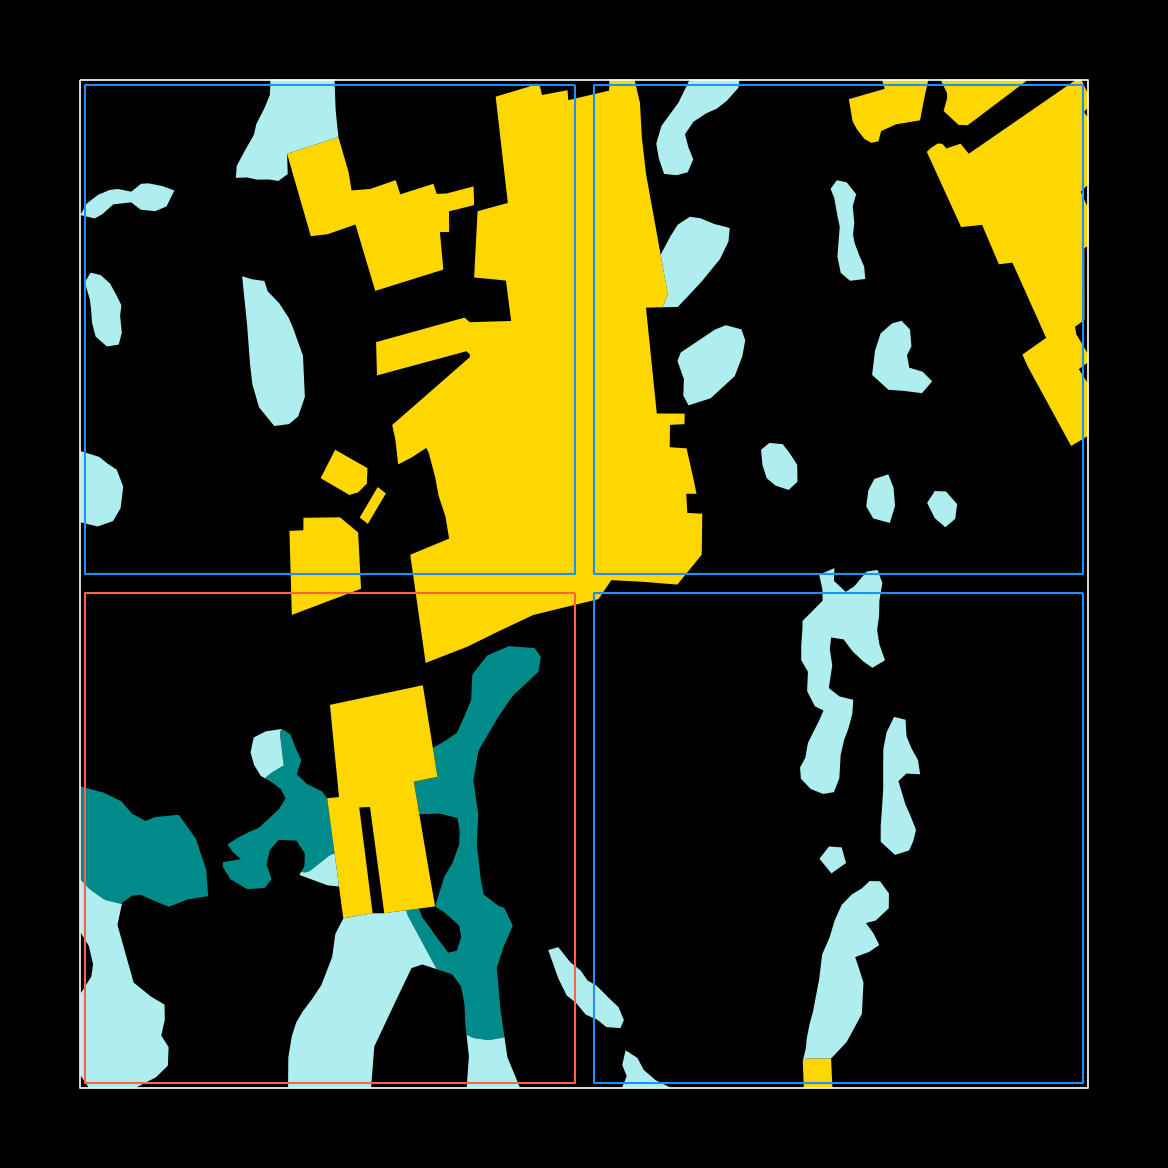

In [56]:
raster_path = "/home/iiro/Documents/Koulutyöt/Gradu/data/predictions/uusi_filtteri_ennuste.tif"

# Counter for the training samples, starts from 909 with older data
j=0

# not efficient but the amount of points is relatively small and the code is run only once
errors = []
# Counting starts from 303 for older data
for i, square in enumerate(squares.iterrows(), 0):
    
    if i != 246:
        continue
    
    # Image tmp path
    image_path = os.path.join(image_tmp_dir, str(i) + '.tif')
    #  Label tmp path
    
    poly = (square[-1]['geometry'])
    plot_poly = geopd.GeoDataFrame(geometry=[poly], crs=annotations.crs)
    corner_points = [i for i in list(poly.exterior.coords)]
    x_W, y_N = corner_points[0]
    x_E, y_S = corner_points[2]
    NW_sample = Point(x_W + sample_offset_m, y_N - sample_offset_m)
    NE_sample = Point(x_E - sample_offset_m, y_N - sample_offset_m)
    SE_sample = Point(x_E - sample_offset_m, y_S + sample_offset_m)
    SW_sample = Point(x_W + sample_offset_m, y_S + sample_offset_m)
    sample_points = geopd.GeoSeries([NW_sample, NE_sample, SE_sample, SW_sample])
    # Square buffer
    sample_squares = sample_points.buffer(sample_buffer_size_m, cap_style=3)
    
    testing_square = sample_squares[3]
    
    annotation_km2 = annotations.cx[x_W: x_E, y_S:y_N]
    
    train_geo_series = geopd.GeoSeries([NW_sample, NE_sample, SE_sample])
    test_geo_series = geopd.GeoSeries([SW_sample])

    # The image is used just to get the correct size
    with rasterio.open(image_path) as image:
    
    fig, ax = plt.subplots()
    #ax = test_geo_series.plot(ax=ax, c='red', markersize=1, zorder=2)
    cmap = ListedColormap(['gold', 'darkcyan', 'paleturquoise'])
    ax = plot_poly.boundary.plot(ax=ax, color='white', linewidth=0.4)
    ax = annotation_km2.plot(ax=ax, column="Täyttöarvo", cmap=cmap)
    ax = train_geo_series.buffer(sample_buffer_size_m, cap_style=3).boundary.plot(ax=ax, color='dodgerblue', linewidth=0.5, zorder=2)
    ax = test_geo_series.buffer(sample_buffer_size_m, cap_style=3).boundary.plot(ax=ax, color='tomato', linewidth=0.5, zorder=3)
    ax.axis('off')
    plt.style.use('dark_background')
    plt.savefig("/home/iiro/Documents/Koulutyöt/Gradu/visualisointi/menetelmät/ruutujako_piirrokset.png", dpi=300, bbox_inches='tight')
    plt.show()
    break

In [52]:
print(raster.shape)

(591, 591)


In [6]:
print(x_W, x_E)

298710.62252597307 299710.62252597307


In [7]:
print(y_S, y_N)

6927990.713773869 6928990.713773869


In [8]:
annotations.head()

,Täyttöarvo,layer,path,geometry
0,2,NaN,NaN,"MULTIPOLYGON (((89553.340 6697366.079, 89549.3..."
1,2,NaN,NaN,"MULTIPOLYGON (((203398.012 6741546.035, 203397..."
2,2,NaN,NaN,"MULTIPOLYGON (((224654.804 6744145.852, 224643..."
3,2,NaN,NaN,"MULTIPOLYGON (((241627.150 6752608.970, 241612..."
4,2,NaN,NaN,"MULTIPOLYGON (((193356.704 6772898.644, 193362..."


In [38]:
square[-1][]

id                                                     235713
left                                            298710.622526
top                                            6928990.713774
right                                           299710.622526
bottom                                         6927990.713774
geometry    POLYGON ((298710.62252597307 6928990.713773869...
Name: 246, dtype: object

<Axes: >

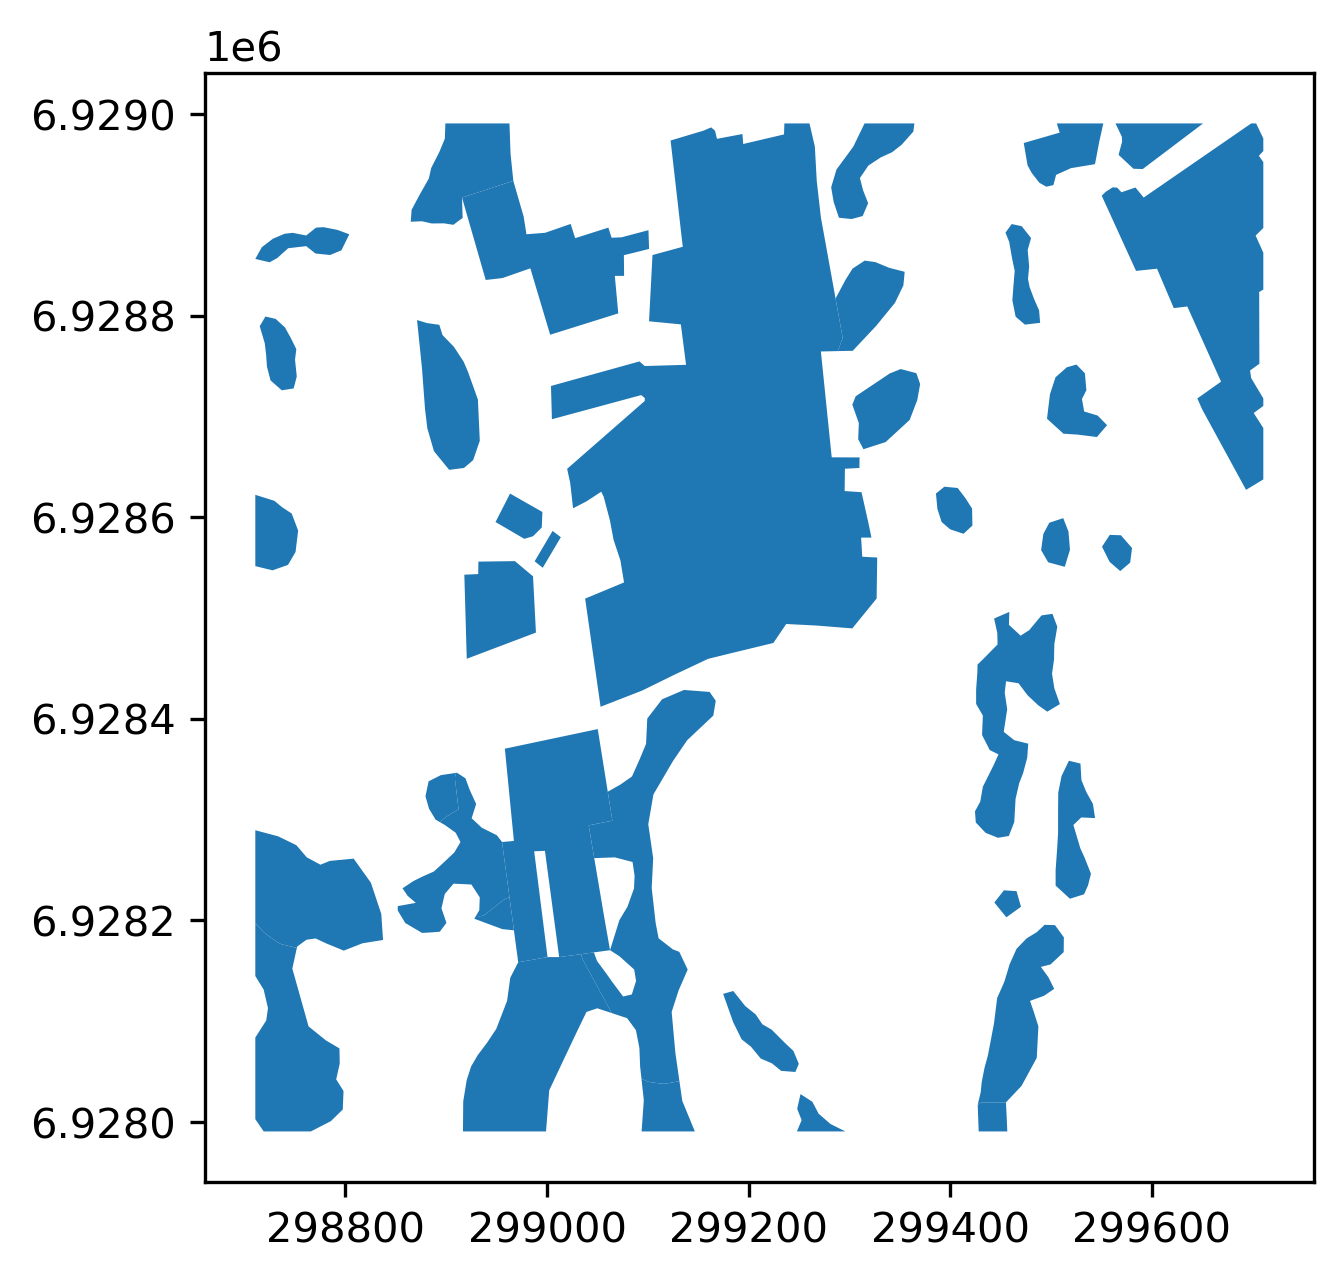

In [11]:
annotation_km2.plot()

<Axes: >

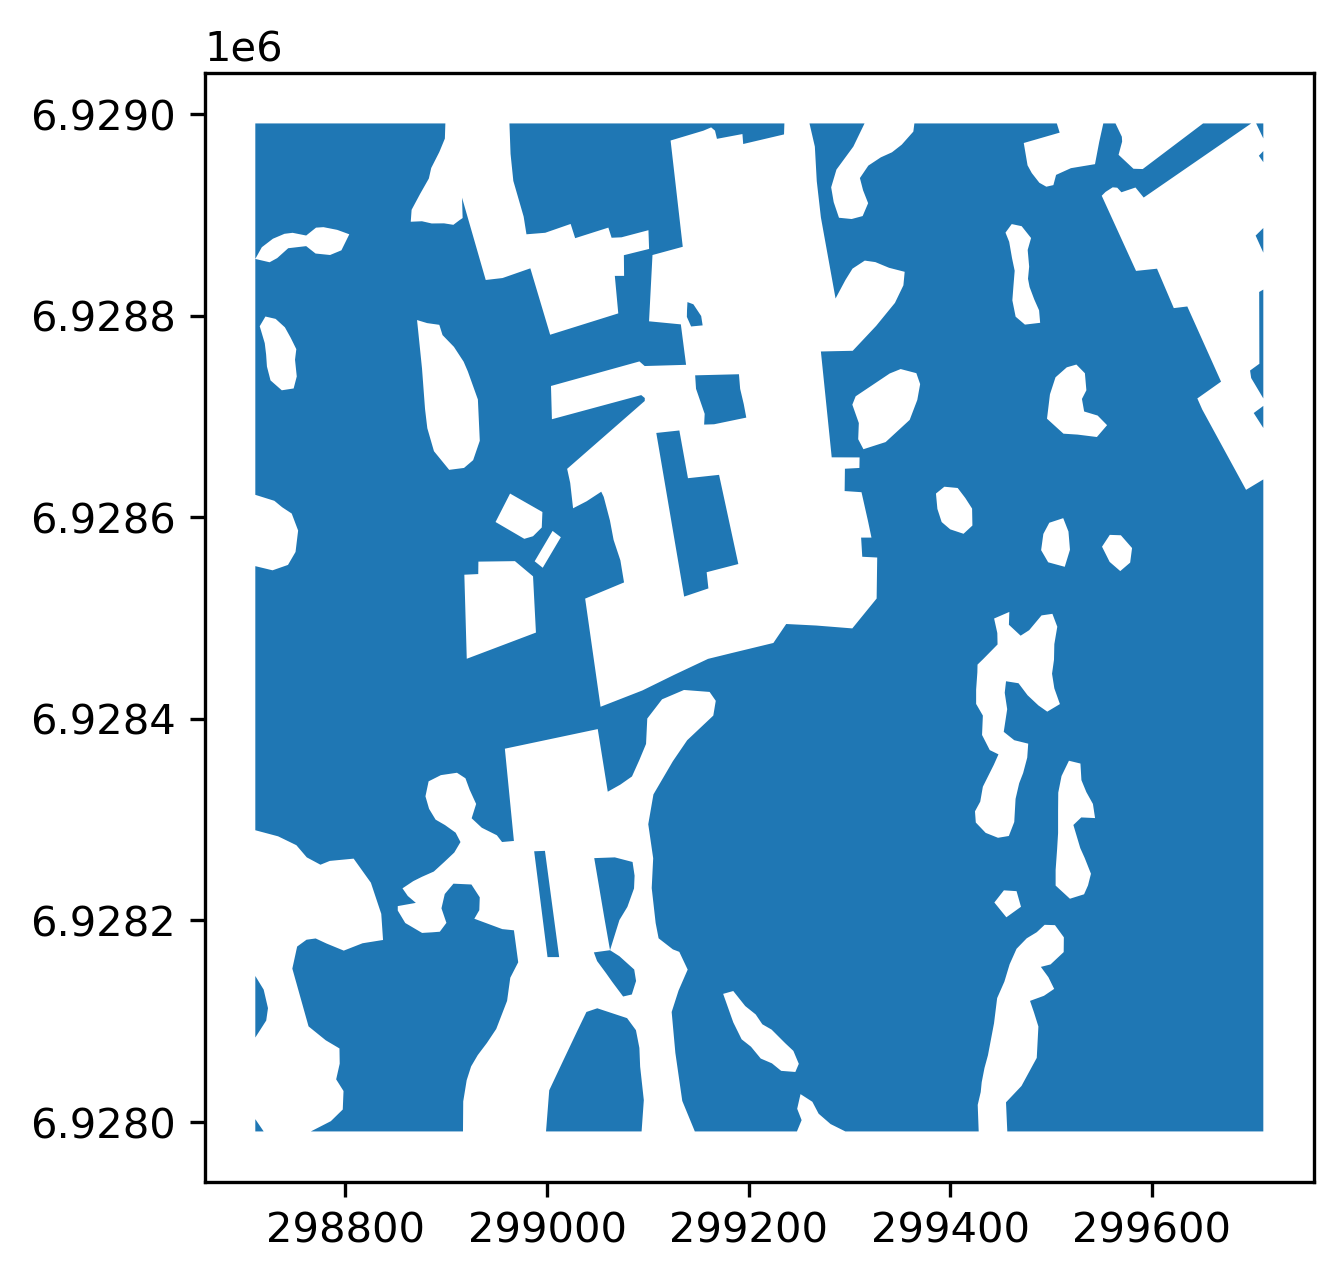

In [11]:
background.plot()

In [60]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']